#Подключаем библиотеки и импортируем данные




In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import data_table
data_table.enable_dataframe_formatter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from itertools import combinations
import networkx as nx

from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn.mixture import GaussianMixture
import networkx.algorithms.community as nx_comm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

Mounted at /content/drive


Функция модулярности.

In [ ]:
def modularity(G, l, num_c):
  com = [set()for i in range(num_c)]
  for i, l in enumerate(l):
    com[l].add(i)
  return nx_comm.modularity(G, com)

Данные.

In [ ]:
X_raw = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/X_4_6.csv', header=None))
Y_raw = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/Y_4_6.csv', header=None))

#Первичная обработка данных

##1. Осмотр данных.

**Основные характеристики данных.**

In [ ]:
X_raw.describe(), Y_raw.describe()

(                0           1           2           3
 count  200.000000  200.000000  200.000000  200.000000
 mean     3.022200    2.002300    0.037400    2.984800
 std      2.609427    1.181437    2.625872    1.708498
 min     -1.950000   -0.230000   -4.640000   -0.030000
 25%      0.987500    1.087500   -2.087500    1.690000
 50%      2.860000    2.015000    0.055000    2.960000
 75%      5.175000    2.890000    1.995000    4.377500
 max      7.620000    4.070000    4.740000    5.960000,
                 0           1           2           3
 count  200.000000  200.000000  200.000000  200.000000
 mean     1.315300    0.619700    0.934650    0.996200
 std      0.496158    0.516646    0.868415    0.176984
 min      0.650000   -0.640000   -0.360000    0.440000
 25%      0.950000    0.097500    0.020000    0.917500
 50%      1.075000    0.875000    1.005000    0.995000
 75%      1.932500    1.040000    1.805000    1.070000
 max      2.250000    1.310000    2.570000    1.910000)

**Гистограммы признаков**

Если присмотреться, кажется, что по признакам 1, 2 данные разделяются на 2 кластера. Хотя возможно они просто равномерно распределены и всё это флуктуации.

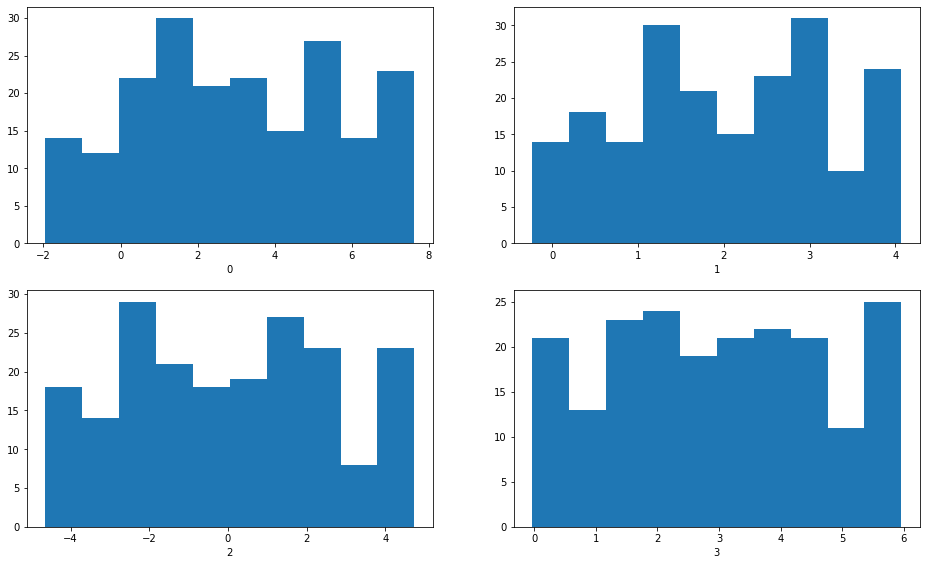

In [ ]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(X_raw.columns):
  plt.subplot(4, 2, i+1)
  plt.hist(X_raw[col])
  plt.xlabel(col)
plt.show()

Видим, что данные Y расделяются на несколько кластеров по признакам 0, 1, 2.

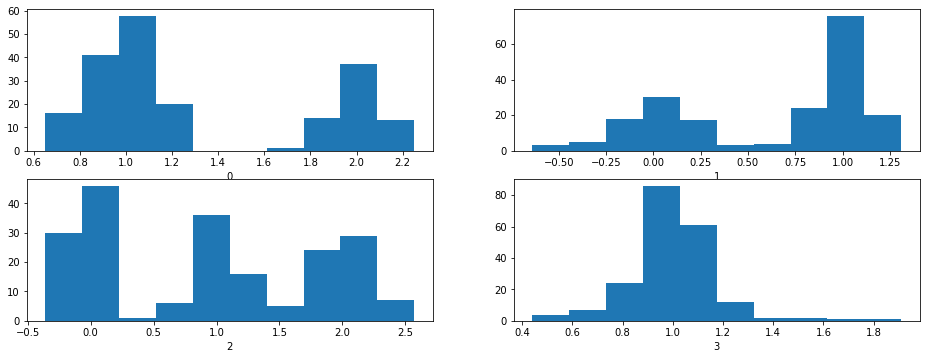

In [ ]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(Y_raw.columns):
  plt.subplot(4, 2, i+1)
  plt.hist(Y_raw[col])
  plt.xlabel(col)
plt.show()

**Ящик с усами**

Для данных X выбросов нет.

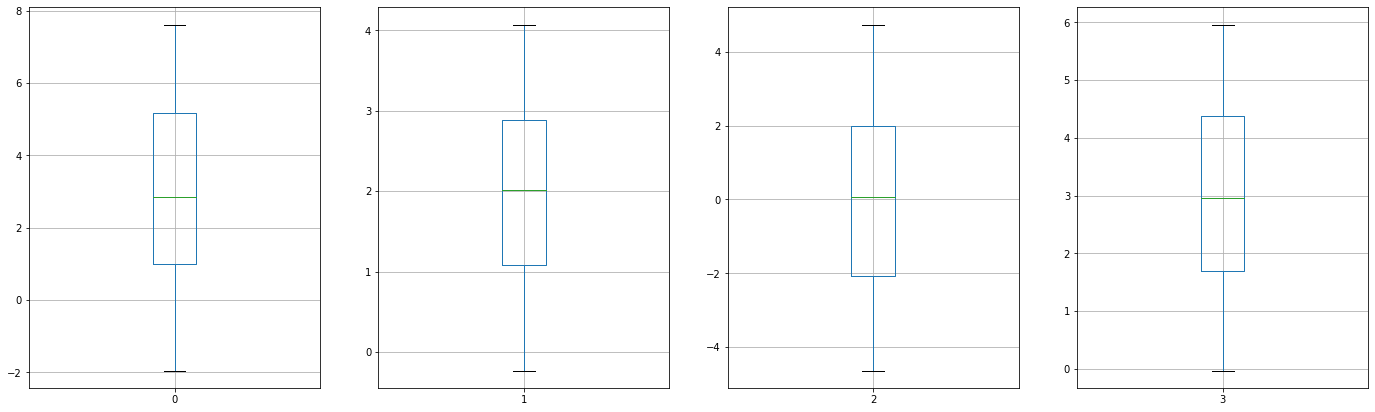

In [ ]:
plt.figure(figsize=(24, 7))
for i, col in enumerate(X_raw.columns):
  plt.subplot(1, 4, i+1)
  X_raw.boxplot(column = col).plot()
plt.show()

Рассмотрим Y.

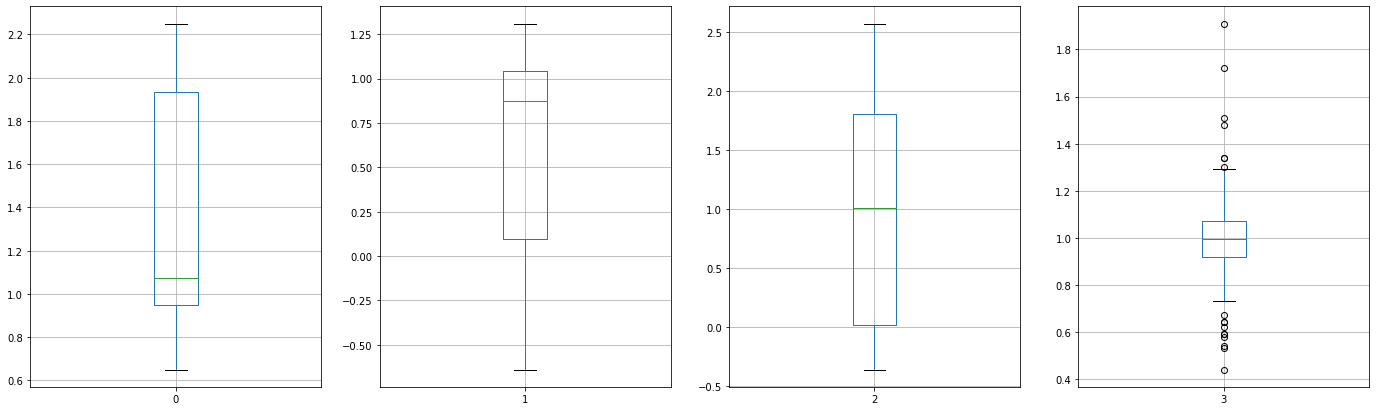

In [ ]:
plt.figure(figsize=(24, 7))
for i, col in enumerate(Y_raw.columns):
  plt.subplot(1, 4, i+1)
  Y_raw.boxplot(column = col).plot()
plt.show()

Имеем следующее количество выбросов:

In [ ]:
q3, q1 = 1.07, 0.9175
q = (q3 - q1) * 1.5
Y_raw[(Y_raw[3] >= q3 + q) | (Y_raw[3] <= q1 - q)].count()[0]

17

##2. Пропуски в данных.

Пропусков нет.

In [ ]:
X_raw.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [ ]:
Y_raw.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

##3. Удаление выбросов.

In [ ]:
Y_without_outlier = Y_raw.loc[(Y_raw[3] <= q3 + q) & (Y_raw[3] >= q1 - q)]

##4. Централизация и нормализация.

Выполняем центрирование данных.

In [ ]:
Y_centered = Y_without_outlier.apply(lambda x: x - x.mean())
X_centered = X_raw.apply(lambda x: x - x.mean())

Выполняем нормировку.

In [ ]:
Y = Y_centered.apply(lambda x: x/np.sqrt(np.sum(np.square(x))))
X = X_centered.apply(lambda x: x/np.sqrt(np.sum(np.square(x))))

#Кластеризация

В пунктах 6 и 7 данные кластеризуются с помощью 4 методов: k-means, em, single linkage, spectral algorithm и сравниваются с помощью RAND index и modularity. Подробный анализ с визуализацией и определением оптимального числа кластеров приводится в пункте 8.

##5. Матрицы расстояний и близостей, графовая модель.

Матрицы расстояний.

In [ ]:
D_X = distance_matrix(X, X)
D_Y = distance_matrix(Y, Y)

Матрицы близости.

In [ ]:
S_X = 1 - (D_X/ D_X.max())
S_Y = 1 - (D_Y/ D_Y.max())

С помощью матрицы близости построим графовые модели данных.

Порог удаления ребра возьмём 0.4(примерно четверть всех рёбер).

In [ ]:
G_X = nx.from_numpy_matrix(S_X, parallel_edges=0)

for u, v in G_X.edges():
  if G_X.edges[u, v]['weight'] < 0.4:
    G_X.remove_edge(u, v)

G_Y = nx.from_numpy_matrix(S_Y, parallel_edges=0)

for u, v in G_Y.edges():
  if G_Y.edges[u, v]['weight'] < 0.4:
    G_Y.remove_edge(u, v)

Обязательно проверим на свзяность!

In [ ]:
nx.is_connected(G_X), nx.is_connected(G_Y)

(True, True)

Начинаем кластериазацию.

In [ ]:
X_labels, Y_labels = dict(), dict()

##6. Кластеризация для k=2

**K-means**

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
X_labels['km_2'] = kmeans.labels_

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(Y)
Y_labels['km_2'] = kmeans.labels_

**EM**

In [ ]:
em = GaussianMixture(n_components=2, init_params='kmeans', max_iter=100, n_init=1)
X_labels['em_2']= em.fit_predict(X)

In [ ]:
em = GaussianMixture(n_components=2, init_params='kmeans', max_iter=100, n_init=1)
Y_labels['em_2']= em.fit_predict(Y)

**Single Linkage**

Используем матрицу расстояний.

In [ ]:
single_linkage = linkage(pdist(X), method='single')
X_labels['sl_2'] = fcluster(single_linkage, t = 2, criterion='maxclust') - 1

In [ ]:
single_linkage = linkage(pdist(Y), method='single')
Y_labels['sl_2'] = fcluster(single_linkage, t = 2, criterion='maxclust') - 1

**Spectral Algorithm**

In [ ]:
spectral = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0).fit(S_X)
X_labels['sa_2'] = spectral.labels_

In [ ]:
spectral = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0).fit(S_Y)
Y_labels['sa_2'] = spectral.labels_

**RAND index и modularity**

In [ ]:
name_lst_2 = ['km_2', 'sl_2', 'sa_2', 'em_2']

**Данные X.**

Заметим, что в X для методов kmeans, em, spectral algorithm примерно первая половина данных относится к одному кластеру, а вторая половина к другому.

Вот, например, разделение на кастеры для kmeans.

In [ ]:
X_labels['km_2']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

В случае single linkage ситуация совсем другая. RAND index подтверждает, что single linkage значительно отличается от других.

In [ ]:
[((i, j), metrics.rand_score(X_labels[i], X_labels[j])) for i, j in combinations(name_lst_2, 2)]

[(('km_2', 'sl_2'), 0.49829145728643215),
 (('km_2', 'sa_2'), 0.9606030150753769),
 (('km_2', 'em_2'), 0.9606030150753769),
 (('sl_2', 'sa_2'), 0.5007035175879397),
 (('sl_2', 'em_2'), 0.49829145728643215),
 (('sa_2', 'em_2'), 0.9228140703517588)]

Видим, что все методы давшие похожие разбиения дали похожие результаты.

Выделяется single linkage. Он дал результат на уровне рандома. Не понятно почему :(

In [ ]:
for i in name_lst_2:
  print('X', i, modularity(G_X, X_labels[i], 2))
print('X', 'random', modularity(G_X, [random.randint(0, 1) for i in range(200)], 2))

X km_2 0.1783445539965058
X sl_2 0.009566570776088662
X sa_2 0.17746646679174383
X em_2 0.1772471172676176
X random 0.008410296018385804


**Данные Y.**

В данных Y все методы дали похожие разбиения, а для пар методов kmeans и spectral algorithm,  em и single linkage разбиения совпали.

In [ ]:
[((i, j), metrics.rand_score(Y_labels[i], Y_labels[j])) for i, j in combinations(name_lst_2, 2)]

[(('km_2', 'sl_2'), 0.9059628895694469),
 (('km_2', 'sa_2'), 1.0),
 (('km_2', 'em_2'), 0.9059628895694469),
 (('sl_2', 'sa_2'), 0.9059628895694469),
 (('sl_2', 'em_2'), 1.0),
 (('sa_2', 'em_2'), 0.9059628895694469)]

Примерно одинаковая модулярность для всех методов.

In [ ]:
for i in name_lst_2:
  print('Y', i, modularity(G_Y, Y_labels[i], 2))

Y km_2 0.2173688406719947
Y sl_2 0.20406354200987428
Y sa_2 0.2173688406719947
Y em_2 0.20406354200987428


##7. Кластеризация для k=3

**K-means**

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
X_labels['km_3'] = kmeans.labels_

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(Y)
Y_labels['km_3'] = kmeans.labels_

**EM**

In [ ]:
em = GaussianMixture(n_components=3, init_params='kmeans', max_iter=100, n_init=1)
X_labels['em_3']= em.fit_predict(X)

In [ ]:
em = GaussianMixture(n_components=3, init_params='kmeans', max_iter=100, n_init=1)
Y_labels['em_3']= em.fit_predict(Y)

**Single Linkage**

Используем матрицу расстояний.

In [ ]:
single_linkage = linkage(pdist(X), method='single')
X_labels['sl_3'] = fcluster(single_linkage, t = 3, criterion='maxclust') - 1

In [ ]:
single_linkage = linkage(pdist(Y), method='single')
Y_labels['sl_3'] = fcluster(single_linkage, t = 3, criterion='maxclust') - 1

**Spectral Algorithm**

In [ ]:
spectral = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=0).fit(S_X)
X_labels['sa_3'] = spectral.labels_

In [ ]:
spectral = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=0).fit(S_Y)
Y_labels['sa_3'] = spectral.labels_

**RAND index и modularity**

In [ ]:
name_lst_3 = ['km_3', 'sl_3', 'sa_3', 'em_3']

**Данные X.**

Видим примерно ту же самую картину, что и для 2 кластеров. Метод single linkage опять значительно отличается от всех остальных.

In [ ]:
[((i, j), metrics.rand_score(X_labels[i], X_labels[j])) for i, j in combinations(name_lst_3, 2)]

[(('km_3', 'sl_3'), 0.5717085427135679),
 (('km_3', 'sa_3'), 0.914321608040201),
 (('km_3', 'em_3'), 0.8018090452261306),
 (('sl_3', 'sa_3'), 0.5778894472361809),
 (('sl_3', 'em_3'), 0.540251256281407),
 (('sa_3', 'em_3'), 0.7643718592964824)]

Один из преддущих кластеров(кластер 0) видимо сохранился, а другой кластер разбился на кластеры 1 и 2.

In [ ]:
X_labels['km_3']

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int32)

Для данных X результаты всех методов, кроме single linkage, незначительно ухудшились. Метод single linkage по прежнему очень плохо работает.

In [ ]:
for i in name_lst_3:
  print(i, modularity(G_X, X_labels[i], 3))

km_3 0.17582747592644532
sl_3 0.04700961100599681
sa_3 0.16760877675218136
em_3 0.17041781493313107


**Данные Y**

В данных Y в этот раз совпали целых 3 метода. Метод spectral algorithm значительно, но не сильно, отличается от остальных.

In [ ]:
[((i, j), metrics.rand_score(Y_labels[i], Y_labels[j])) for i, j in combinations(name_lst_3, 2)]

[(('km_3', 'sl_3'), 1.0),
 (('km_3', 'sa_3'), 0.8024980483996877),
 (('km_3', 'em_3'), 1.0),
 (('sl_3', 'sa_3'), 0.8024980483996877),
 (('sl_3', 'em_3'), 1.0),
 (('sa_3', 'em_3'), 0.8024980483996877)]

Для данных Y результаты улучшились(кроме метода spectral algorithm).

In [ ]:
for i in name_lst_3:
  print(i, modularity(G_Y, Y_labels[i], 3))

km_3 0.22944941112635947
sl_3 0.22944941112635947
sa_3 0.2054997848447593
em_3 0.22944941112635947


##Промежуточный вывод

Для данных X все методы кроме single linkage нашли примерно одно и то же разбиение и показали неплохую модулярность. Для 2 кластеров оценка лучше чем для 3. 3 кластера получились из первых двух разбиением одно из кластеров 2 части. Видимо, данные Х разбиваются на 2 кластера.

Для данных Y все методы показывают примерно похожие результаты и по самим разбиениям и, как следствие, по модулярности. Для 3 кластеров модулярность выше. Видимо данные Y разбиваются больше чем на 2 кластера.

##8. Кластеризация в общем случае

###8.1. Коэффициента Силуэта

Сравним значения коэффициента Силуэта со значениями модулярности для разных разбиений на кластеры.

Для данных Х получили, по сути, аналогичный результат.

In [ ]:
tmp = pd.DataFrame()
name, mod, sil = [], [], []
for i in name_lst_2 + name_lst_3:
  name.append(i)
  mod.append(modularity(G_X, X_labels[i], int(i[-1])))
  sil.append(silhouette_score(X, X_labels[i], metric = 'euclidean'))
tmp['method'] = name
tmp['modularity'] = mod
tmp['silhouette'] = sil

tmp

,method,modularity,silhouette
0,km_2,0.178345,0.417733
1,sl_2,0.009567,0.057122
2,sa_2,0.177466,0.417297
3,em_2,0.177247,0.416188
4,km_3,0.175827,0.401566
5,sl_3,0.047010,0.089178
6,sa_3,0.167609,0.388327
7,em_3,0.170418,0.391184


Для данных Y тоже ничего интересного.

In [ ]:
tmp = pd.DataFrame()
name, mod, sil = [], [], []
for i in name_lst_2 + name_lst_3:
  name.append(i)
  mod.append(modularity(G_Y, Y_labels[i], int(i[-1])))
  sil.append(silhouette_score(Y, Y_labels[i], metric = 'euclidean'))
tmp['method'] = name
tmp['modularity'] = mod
tmp['silhouette'] = sil

tmp

,method,modularity,silhouette
0,km_2,0.217369,0.466638
1,sl_2,0.204064,0.481003
2,sa_2,0.217369,0.466638
3,em_2,0.204064,0.481003
4,km_3,0.229449,0.499495
5,sl_3,0.229449,0.499495
6,sa_3,0.205500,0.419990
7,em_3,0.229449,0.499495


Теперь с помощью этого коэффициента попробуем оценить количество кластеров.
Для этого будем использовать метод k-means.

**Данные X**

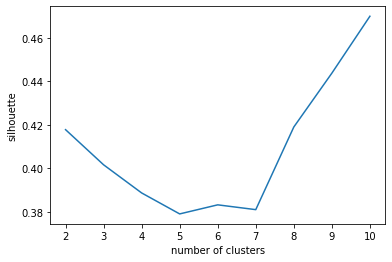

In [ ]:
sil = []
kmax = 10
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))
plt.plot([i for i in range(2, kmax+1)], sil)
plt.xlabel('number of clusters')
plt.ylabel('silhouette')
plt.show()

В точке 2 имеется локальный максимум. Кроме того, мы и раньше предполагаль, что в данных Х маленькое количество кластеров. Так что данный график можно считать подтверждением нашей гипотезы.

**Данные Y**

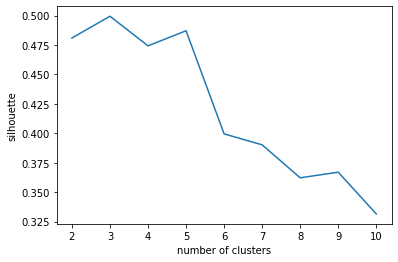

In [ ]:
sil = []
kmax = 10
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(Y)
  labels = kmeans.labels_
  sil.append(silhouette_score(Y, labels, metric = 'euclidean'))
plt.plot([i for i in range(2, kmax+1)], sil)
plt.xlabel('number of clusters')
plt.ylabel('silhouette')
plt.show()

В данном случае локальный максимум в точке 3. Что соответствует нашей гипотезе о том, что в данных Y 3 или более кластера. Видимо их всё таки 3.

##8.2. Метод визуализации данных

Размерность наших данных небольшая, поэтому можно попробовать понизить размерность и провизуализировать их. Для понижения размерности будем использовать svd разложение.

**Данные X.**

In [ ]:
Z = X.to_numpy()
U, S, V = np.linalg.svd(Z, full_matrices = False)
pd.DataFrame([[round(i, 3) for i in S], [round(100*(i)**2/np.sum(np.square(S)), 3) for i in S]], index=['sing_val', '%'])

,0,1,2,3
sing_val,1.599,1.201,0.002,0.001
%,63.933,36.066,0.000,0.000


Почти ничего не теряем.

In [ ]:
print(100 * (np.sum(np.square(S[2:]))/np.sum(np.square(S))),'%')

0.00013843781853924421 %


Метод single linkage, который показывал очень плохую модулярность очень хорошо разбивает данные на 2 кластера.

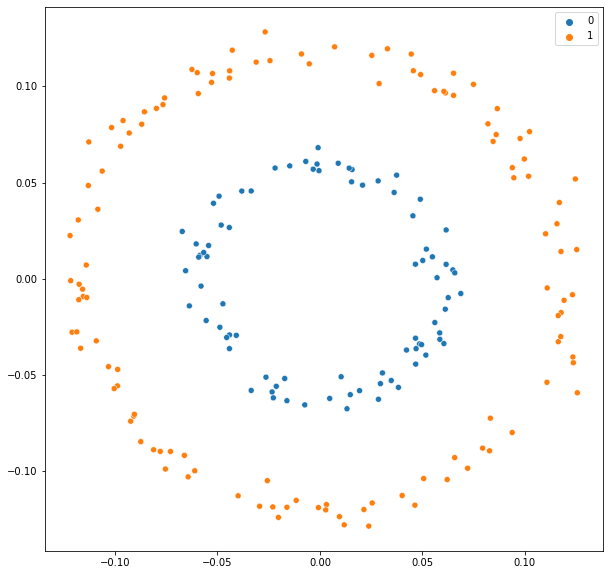

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=U[:, 0], y=U[:, 1], hue=X_labels['sl_2'])
plt.show()

Для других трёх методов(с хорошей модулярностью) разбиение уже не выглядит таким логичным. Например, для метода em(напомним, что для методов k-means и spectral algorithm получились аналогичные разбиения) оно выглядит так:

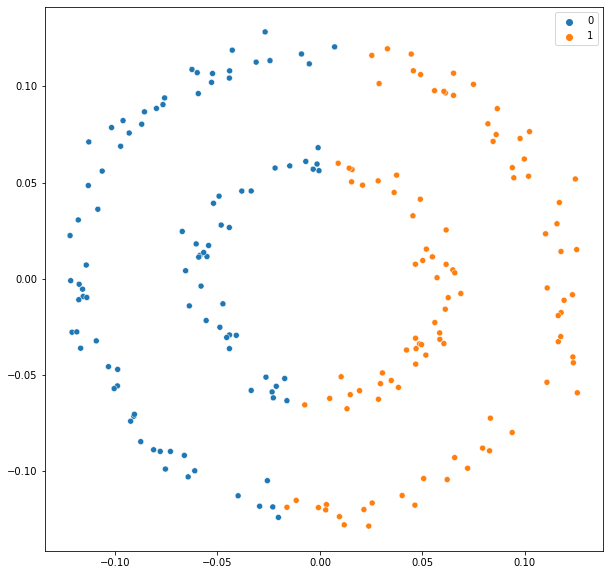

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=U[:, 0], y=U[:, 1], hue=X_labels['em_2'])
plt.show()

**Вывод: наилучшее разбиение для данных X получается методом single linkage, а оптимальное количество кластеров равно 2.**

**Данные Y**

Посмотрим на различные двумерные проекции данных Y.

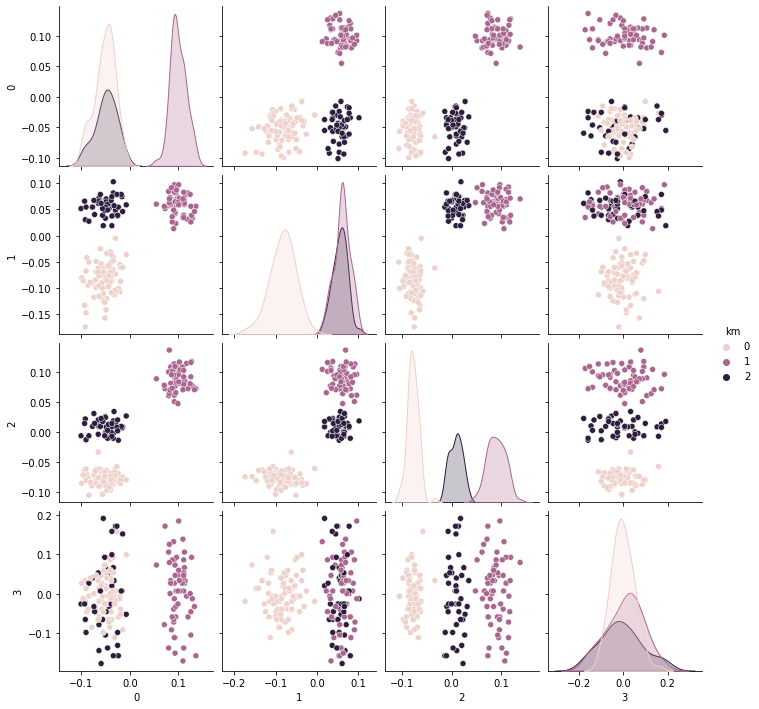

In [ ]:
tmp = Y.copy()
tmp['km'] = Y_labels['km_3']
sns.pairplot(tmp, hue='km')

Тут ситуация сложнее чем для данных X. Видимо данные разбиваются на 3 кластера, 2 из которых в некоторых проекциях сливаются в один.

Понизим размерность.

In [ ]:
Z = Y.to_numpy()
U, S, V = np.linalg.svd(Z, full_matrices = False)
pd.DataFrame([[round(i, 3) for i in S], [round(100*(i)**2/np.sum(np.square(S)), 3) for i in S]], index=['sing_val', '%'])

,0,1,2,3
sing_val,1.589,0.999,0.640,0.259
%,63.140,24.956,10.227,1.678


Понижаем на 1 размерность и теряем всего:

In [ ]:
print(round(100 * (np.sum(np.square(S[3:]))/np.sum(np.square(S))), 5),'%')

1.67755 %


На графике отлично видим разбиение на 3 кластера.

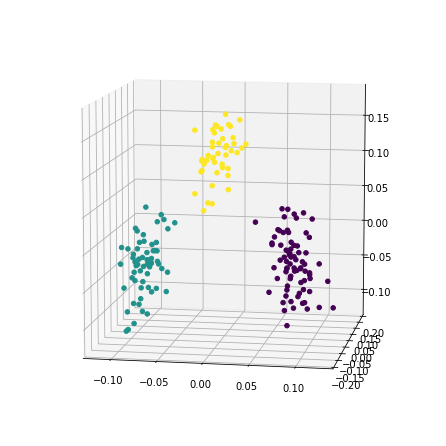

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(xs=U[:, 0], ys=U[:, 1], zs=U[:, 2],  c=Y_labels['em_3'], alpha=1)
ax.view_init(10, -80)
plt.show()

Напомним, что для всех методов, кроме spectral algorithm, мы получили абсолютно одинаковые разбиения. Посмотрим, что получается для этого метода.

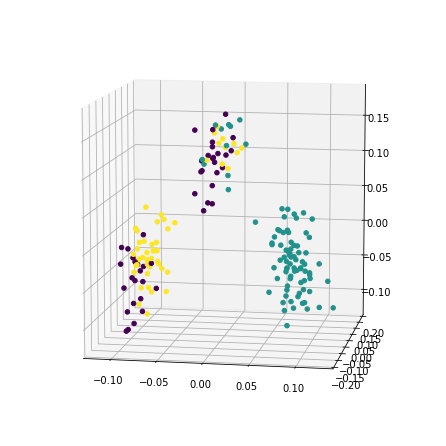

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(xs=U[:, 0], ys=U[:, 1], zs=U[:, 2],  c=Y_labels['sa_3'], alpha=1)
ax.view_init(10, -80)
plt.show()

В данном случае видим не очень хорошее разбиение.

**Вывод: наилучшее разбиение для данных Y получается методами em, k-means, single linkage, а оптимальное количество кластеров равно 3.**

In [ ]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/lab_2_clustering.ipynb

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/lab_2_clustering.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.an

CalledProcessError: ignored